# Variable environments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import warnings

import helper


/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:69: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:90: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [85]:
root="~/Documents/GitHub/CA_GRN2/results_new_rules/"
season_len = 300

def get_fits(rules, seed_ints, metric, exprapolate=True):
    vari_maxs=[np.loadtxt(os.path.expanduser(root+f"stats_{season_len}_{rules[0]}-{rules[1]}_{seed_ints[0]}-{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(5)]
    if rules[0] == rules[1]:
            if rules[0] in [154,82,86,18]:
                env1_maxs=[np.loadtxt(os.path.expanduser(root+f"stats_0_{rules[0]}_{seed_ints[0]}_{i+1}_{metric}.txt")) for i in range(5)]
                env2_maxs=[np.loadtxt(os.path.expanduser(root+f"stats_0_{rules[0]}_{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(5)]
            else:
                env1_maxs=[np.loadtxt(os.path.expanduser(root+f"stats_600_{rules[0]}_{seed_ints[0]}_{i+1}_{metric}.txt")) for i in range(5)]
                env2_maxs=[np.loadtxt(os.path.expanduser(root+f"stats_600_{rules[0]}_{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(5)]
    else:
        print("scenario not yet implemented")

    if exprapolate:
        diff_len = len(vari_maxs[0]) - len(env1_maxs[0])
        if diff_len > 1:
            env1_maxs=np.array(env1_maxs)
            env2_maxs=np.array(env2_maxs)
            last_elements = env1_maxs[:,-1]
            last_elements=np.tile(last_elements, (diff_len, 1)).T
            env1_maxs = np.hstack((env1_maxs, last_elements))
            last_elements = env2_maxs[:,-1]
            last_elements=np.tile(last_elements, (diff_len, 1)).T
            env2_maxs = np.hstack((env2_maxs, last_elements))

    return vari_maxs, env1_maxs, env2_maxs

def chunker(runs, season_len = 300):
    florp = np.array(runs).mean(axis=0) # average runs
    n_seasons = int(np.floor(florp.shape[0]/season_len))
    chunked_seasons = np.array([florp[i*300:(i+1)*300] for i in range(n_seasons)])
    assert chunked_seasons.size == season_len * n_seasons #safety check
    chunked_season1, chunked_season2 = chunked_seasons[0::2], chunked_seasons[1::2]
    max_chunked_season1, max_chunked_season2 = chunked_season1.max(axis=1),chunked_season2.max(axis=1)
    return max_chunked_season1.max(), max_chunked_season2.max()

def scatter_value(variable, season1, season2, season_len):
    vari_env1, vari_env2 = chunker(variable, season_len=season_len)
    M_env1 = np.array(season1).mean(axis=0).max()
    M_env2 = np.array(season2).mean(axis=0).max()
    diffs = (vari_env1 - M_env1, vari_env2 - M_env2)
    return diffs

In [86]:
seed_ints = [69904,149796]

In [87]:
xs = []
ys = []
rules=np.array([22, 126, 146, 154, 82, 86, 18, 118, 122, 70])#np.array([54,94,30,50,62,110,90,150,102,254])
for rule in rules:
    vari_maxs, env1_maxs, env2_maxs=get_fits([rule,rule], seed_ints, "maxfits")
    x,y = scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
    xs.append(x)
    ys.append(y)

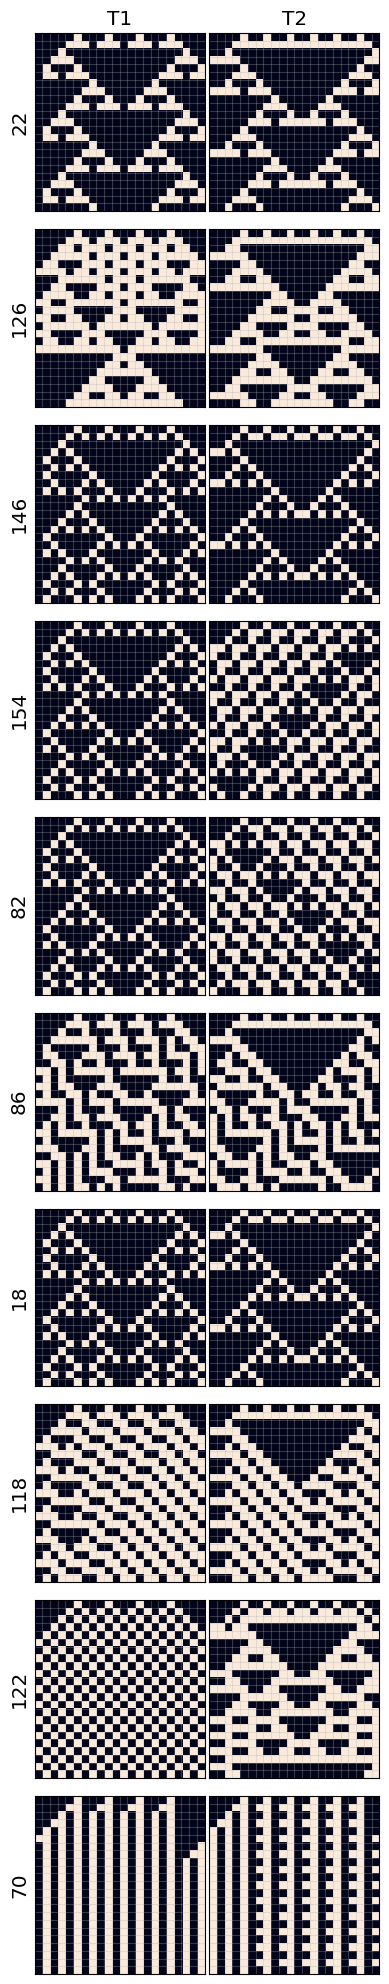

In [88]:
nrows = len(rules)
ncols = 2
scale=2
dev_steps=22
num_cells=22

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * scale, nrows*scale), sharex=True, sharey=True)
#ax.set_title(f"Rule: {rules[i]}", fontsize=16)

axs = axs.flatten()
counter=0
rcounter=0
targets=[]
for i, ax in enumerate(axs):
    if counter % 2 == 0:
        start_pattern = helper.seedID2string(seed_ints[0], num_cells)
        target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        #print("one",rules[rcounter])
        ax.set_ylabel(rules[rcounter], rotation=90, size='large')
        targets.append(target)
    else:
        start_pattern = helper.seedID2string(seed_ints[1], num_cells)
        target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        #print("two",rules[rcounter])
        rcounter+=1
        targets.append(target)
    helper.imshow_ca(target,ax=ax)
    counter+=1

for ax, col in zip(axs, ["T1","T2"]):
    ax.set_title(col)

plt.tight_layout()
plt.show()

/var/folders/41/13rhly317ygcfk0c_1jggxch0000gn/T/ipykernel_44797/3373592845.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/41/13rhly317ygcfk0c_1jggxch0000gn/T/ipykernel_44797/3373592845.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


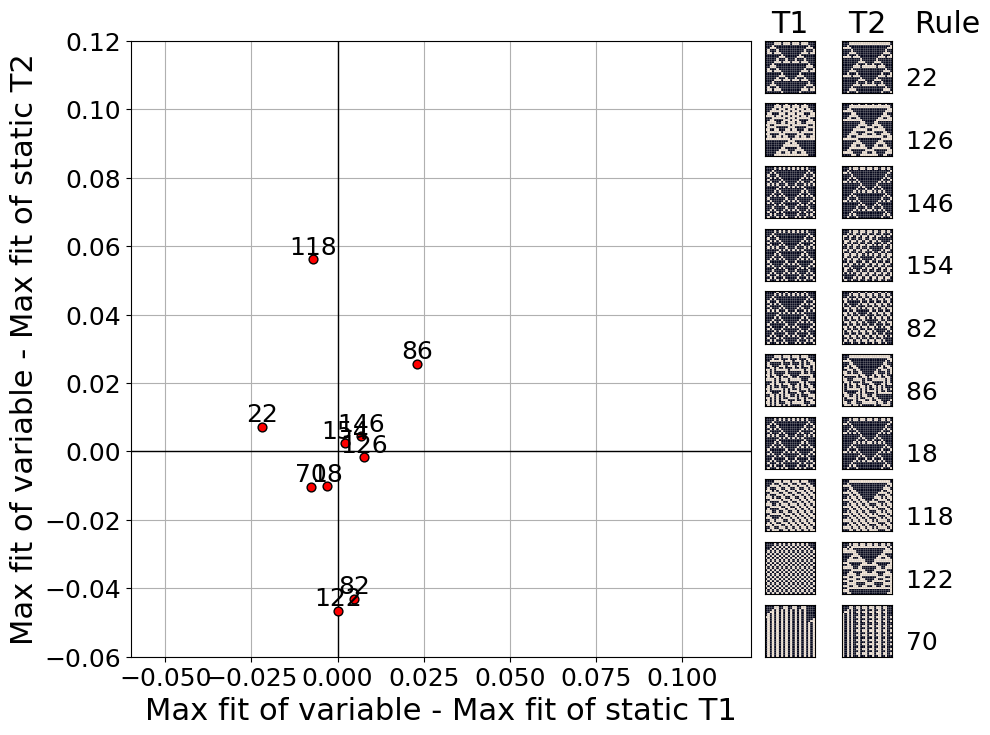

In [89]:
def main_plt(xs, ys, rules, ax):

    ax.scatter(xs, ys, s=40, zorder=3, color="red", edgecolors="black")
    fontsize = 18

    for i, label in enumerate(rules):
        if label == 254:
            ax.annotate(
                label,
                fontsize=fontsize,
                xy=(xs[i], ys[i]),
                xytext=(xs[i] - 0.03, ys[i] + 0.02),
                arrowprops=dict(
                    facecolor="black", shrink=0.05, width=0.2, headwidth=3, headlength=5
                ),
            )
        elif label == 50:
            ax.annotate(
                label,
                fontsize=fontsize,
                xy=(xs[i], ys[i]),
                xytext=(xs[i] + 0.01, ys[i] + 0.02),
                arrowprops=dict(
                    facecolor="black", shrink=0.05, width=0.2, headwidth=3, headlength=5
                ),
            )
        else:
            ax.text(
                xs[i],
                ys[i],
                label,
                fontsize=fontsize,
                ha="center",
                va="bottom",
                color="black",
            )

    ax.set_xlim(-0.06, 0.12)
    ax.set_ylim(-0.06, 0.12)
    ax.axvline(0, lw=1, color="black")
    ax.axhline(0, lw=1, color="black")
    ax.set_xlabel("Max fit of variable - Max fit of static T1",fontsize=22)
    ax.set_ylabel("Max fit of variable - Max fit of static T2",fontsize=22)
    ax.grid(zorder=0)


Ts = [
    targets[0::2],
    targets[1::2],
]

#xs,ys=pickle.load(open("2env_scatter.p", "rb"))

#rules_ims=[102,54,62,50,254,30,90,150,94,110]
#rules_scatter=[54,94,30,50,62,110,90,150,102,254]

plt.rcParams["font.size"] = 18

fig = plt.figure(constrained_layout=True, figsize=(10,8))
gs = fig.add_gridspec(10, 10, wspace=0.0, hspace=0.2)
ax = fig.add_subplot(gs[:, :8])

main_plt(xs, ys, rules, ax)

for T in [0, 1]:
    for i in range(len(rules)):
        ax = fig.add_subplot(gs[i, 8 + T])
        if i == 0 and T == 0:
            ax.set_title(f"T{T+1}", ha="center")
        if i == 0 and T == 1:
            ax.set_title(f"          T{T+1}   Rule", ha="center")
        if T == 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f" {rules[i]}", rotation="horizontal", ha="left")
        helper.imshow_ca(Ts[T][i], ax=ax)
plt.tight_layout()
plt.show()
#plt.savefig("figs/2envinp_scatter.png")

In [90]:
root="~/Documents/GitHub/CA_GRN2/results_new_rules/"
root="~/Documents/GitHub/CA_GRN2/results_testing_L1_01_good/"
season_len = 300
metric = "maxfits"
rules=[86,86]

vari_maxs=[np.loadtxt(os.path.expanduser(root+f"stats_{season_len}_{rules[0]}-{rules[1]}_{seed_ints[0]}-{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(5)]

vari_maxs[0]
    

array([0.58147984, 0.58147984, 0.59873078, ..., 0.76624595, 0.76624595,
       0.76624595])

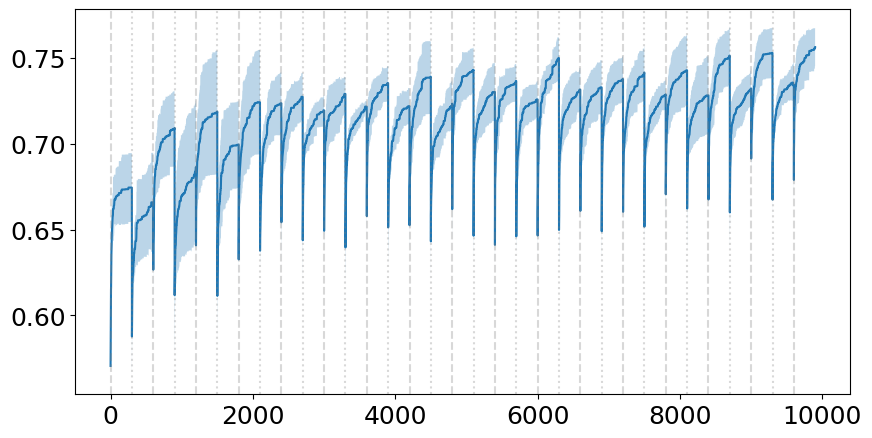

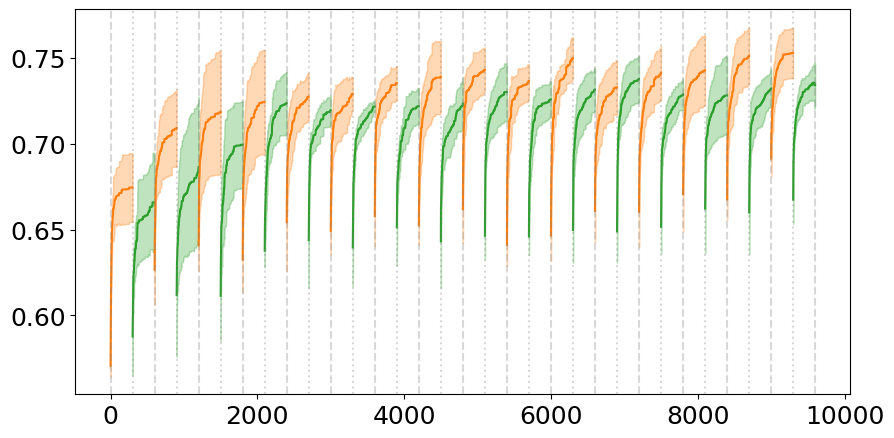

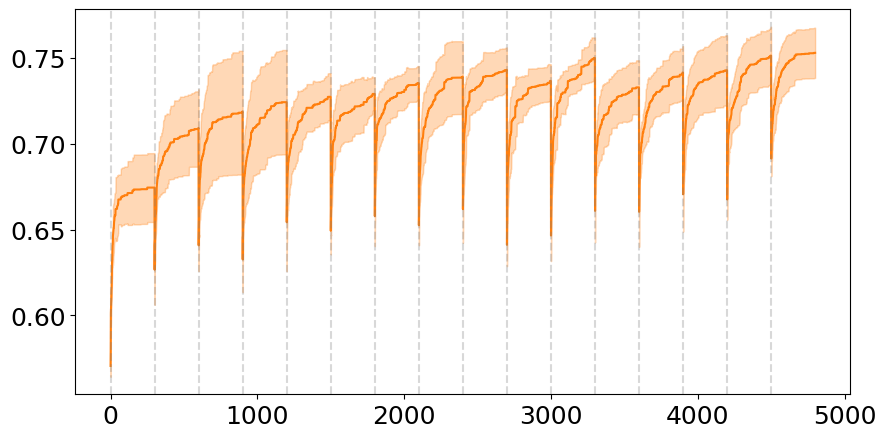

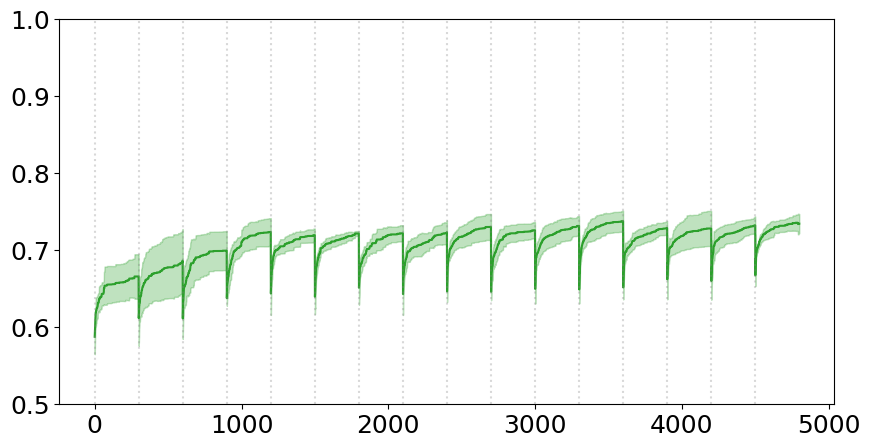

In [91]:
def chunker_plotting(run, season_len = 300):
    gens=list(range(len(run)))
    n_seasons = int(np.floor(run.shape[0]/season_len))
    chunked_seasons = np.array([run[i*300:(i+1)*300] for i in range(n_seasons)])
    chunked_gens = np.array([gens[i*300:(i+1)*300] for i in range(n_seasons)])

    assert chunked_seasons.size == season_len * n_seasons #safety check

    chunked_season1, chunked_season2 = chunked_seasons[0::2], chunked_seasons[1::2]
    chunked_gens1, chunked_gens2 = chunked_gens[0::2], chunked_gens[1::2]
    
    return chunked_season1, chunked_season2, chunked_gens1, chunked_gens2

#all_maxs=get_fits([rule,rule], seed_ints, "avefits")

#plot all variable, together
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
m=vari_maxs #all_maxs[0]
mean1 = np.mean(m, axis=0)
stderr1 = np.std(m, axis=0) #/ np.sqrt(len(m))
ax.fill_between(range(len(mean1)), mean1 - stderr1, mean1 + stderr1, alpha=0.3)
ax.plot(mean1, "-")
for j in range(0, len(mean1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)


#put together with color
season1, season2, gens1, gens2 = chunker_plotting(mean1, season_len = 300)
season1_std, season2_std, _, _ = chunker_plotting(stderr1, season_len = 300)
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
for i in range(len(gens1)):
    ax.plot(gens1[i], season1[i],color="C1")
    ax.fill_between(gens1[i], season1[i] - season1_std[i], season1[i] + season1_std[i], alpha=0.3,color="C1")
    ax.plot(gens2[i], season2[i],color="C2")
    ax.fill_between(gens2[i], season2[i] - season2_std[i], season2[i] + season2_std[i], alpha=0.3,color="C2")
for j in range(0, len(mean1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
plt.show()

#chunk it up!
season1, season2, _, _ = chunker_plotting(mean1, season_len = 300)
season1 = np.reshape(season1, (season1.shape[0]*season1.shape[1]))
season2 = np.reshape(season2, (season2.shape[0]*season2.shape[1]))

season1_std, season2_std, _, _ = chunker_plotting(stderr1, season_len = 300)
season1_std = np.reshape(season1_std, (season1_std.shape[0]*season1_std.shape[1]))
season2_std = np.reshape(season2_std, (season2_std.shape[0]*season2_std.shape[1]))

fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
ax.plot(season1,color="C1")
ax.fill_between(range(len(season1)), season1 - season1_std, season1 + season1_std, alpha=0.3,color="C1")
for j in range(0, len(season1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
plt.show()

fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
ax.plot(season2,color="C2")
ax.fill_between(range(len(season2)), season2 - season2_std, season2 + season2_std, alpha=0.3,color="C2")
for j in range(0, len(season2), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)


plt.ylim(0.5,1)
plt.show()



FileNotFoundError: /Users/csengepetak/Documents/GitHub/CA_GRN2/results_testing_L1_01_good/stats_0_86_69904_1_maxfits.txt not found.

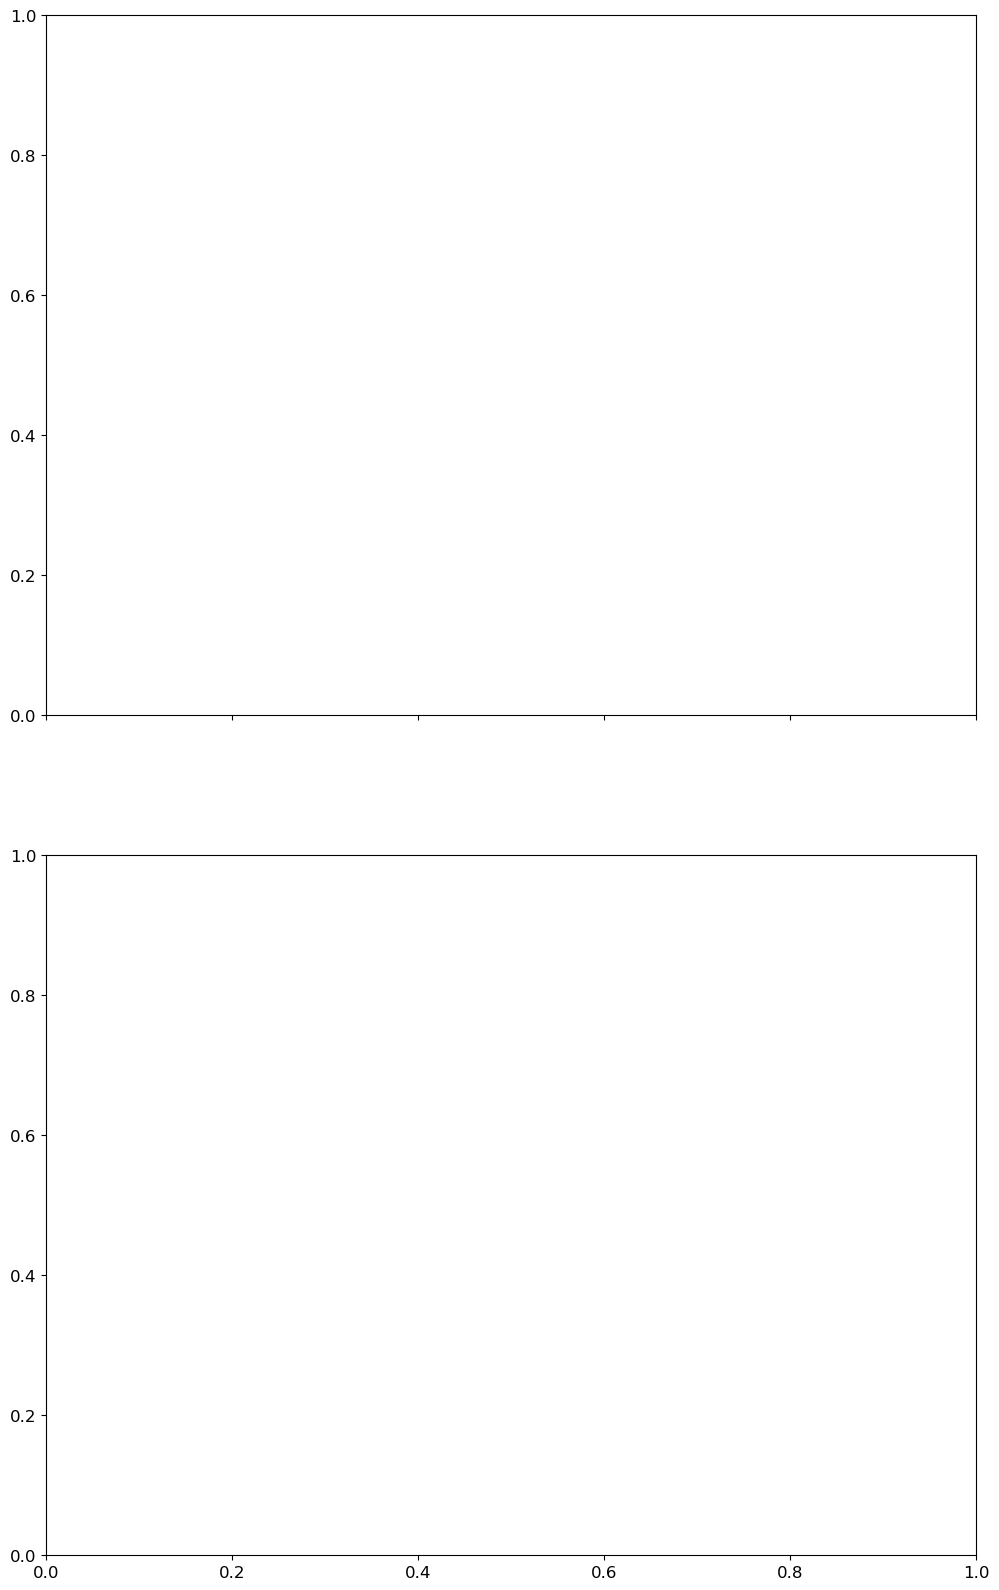

In [92]:
plt.rcParams["font.size"] = 12

def plot_three_line(ax,rule,seed_ints, data_type, season_len, legend):

    all_maxs=get_fits([rule,rule], seed_ints, data_type)
    labels=["vari","env1","env2"]
    for i,m in enumerate(all_maxs):
        mean1 = np.mean(m, axis=0)
        stderr1 = np.std(m, axis=0) / np.sqrt(len(m))
        ax.fill_between(range(len(mean1)), mean1 - stderr1, mean1 + stderr1, alpha=0.3)
        ax.plot(mean1, "-", label=labels[i])

    for j in range(0, len(mean1), season_len):
        if j % (season_len * 2) == 0:
            ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
        else:
            ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
    
    # Plot data

    ax.tick_params(right=True, labelright=False)

    ax.set_title(f"Rule {str(rule)}, {data_type}")
    #ax.grid(axis="y")
    #ax.set_ylabel("Fitness")
    #plt.savefig("rule_"+str(rule)+"_lines.png")

    if legend == 0:
        ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
        height = 0.75
        base = season_len/2
        kwargs = {"ha":"center", "va":"center", "fontsize":12, "color":"gray"}
        ax.text(base, height, "T1", **kwargs)
        ax.text(base + season_len, height, "T2", **kwargs)
        ax.text(base + season_len*2, height, "T1", **kwargs)
        ax.text(base + season_len*3, height, "T2", **kwargs)
    

fig, axs=plt.subplots(nrows=len(rules),ncols=1, figsize=(12, 20),sharex=True) #sharey=True)

for i,rule in enumerate(rules):
    plot_three_line(axs[i],rule,seed_ints, "maxfits", season_len=300, legend=i)

# Add labels and legend
#plt.xlabel('Generations')
#plt.ylabel('Max fitness')
#plt.title(rule)
#plt.legend(loc='upper left')

fig.text(0.5, 0, 'Generations', ha='center',fontsize=22)
fig.text(0, 0.5, 'Max fitness', va='center', rotation='vertical',fontsize=22)

#plt.ylim(0.6,1)
plt.xlim(0,10_000)
#plt.tight_layout()
#plt.savefig("figs/rule_lines.png")

In [38]:
gensin=[10,100,290]
swichesin=[3,10,15,25,32]
saveat=[s*300+g for s in swichesin for g in gensin]

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import helper



In [62]:
root="results_testing_L1_01_good"
#root="results_new_rules"

def try_grn(variable, rule, run_seedints, try_seedints, grn_size, geneid):
    last_grns=[]
    for i in range(5):
        if variable:
            filename = f"{root}/stats_300_{rule}-{rule}_{run_seedints[0]}-{run_seedints[1]}_{i+1}" + "_best_grn.txt"
        else:
            if rule in [154,82,86,18]:
                filename = f"results_new_rules/stats_0_{rule}_{run_seedints}_{i+1}" + "_best_grn.txt"
            else:
                filename = f"results_new_rules/stats_600_{rule}_{run_seedints}_{i+1}" + "_best_grn.txt"
        grns = np.loadtxt(filename)
        num_grns = int(grns.shape[0]/(grn_size+2)/grn_size)
        grns = grns.reshape(num_grns,grn_size+2,grn_size)
        grn = grns[-1,:,:]
        last_grns.append(grn)
    last_grns = np.array(last_grns)

    last_phenos=[]
    fits = []
    for s in try_seedints:
        targets, phenos, fitnesses = helper.get_pop_TPF(last_grns, len(last_grns), num_cells, grn_size, dev_steps, geneid, rule, s)
        last_phenos.append(phenos)
        fits.append(fitnesses)
    last_phenos = np.array(last_phenos)
    fits = np.array(fits)
    return last_phenos, fits, last_grns

In [63]:
# Load GRN

# Parameters
rule = 86
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1 #which gene was used to get fitness
seed_ints = [69904,149796]
try_seedints = [69904,149796,1024, 4147842,1238860,2481300]

#Targets
all_targs=[]
for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, rule, s)
    all_targs.append(targets)

#Check GRNs from the last generation
varied_phenos, varied_fits, varied_genos = try_grn(True, rule, seed_ints, try_seedints, grn_size, geneid)
env1_phenos, env1_fits, env1_genos = try_grn(False, rule, seed_ints[0], try_seedints, grn_size, geneid)
env2_phenos, env2_fits, env2_genos = try_grn(False, rule, seed_ints[1], try_seedints, grn_size, geneid)

varied_df = pd.DataFrame(varied_fits.T, columns = try_seedints)
env1_df = pd.DataFrame(env1_fits.T, columns = try_seedints)
env2_df = pd.DataFrame(env2_fits.T, columns = try_seedints)
dfs=[varied_df, env1_df, env2_df]


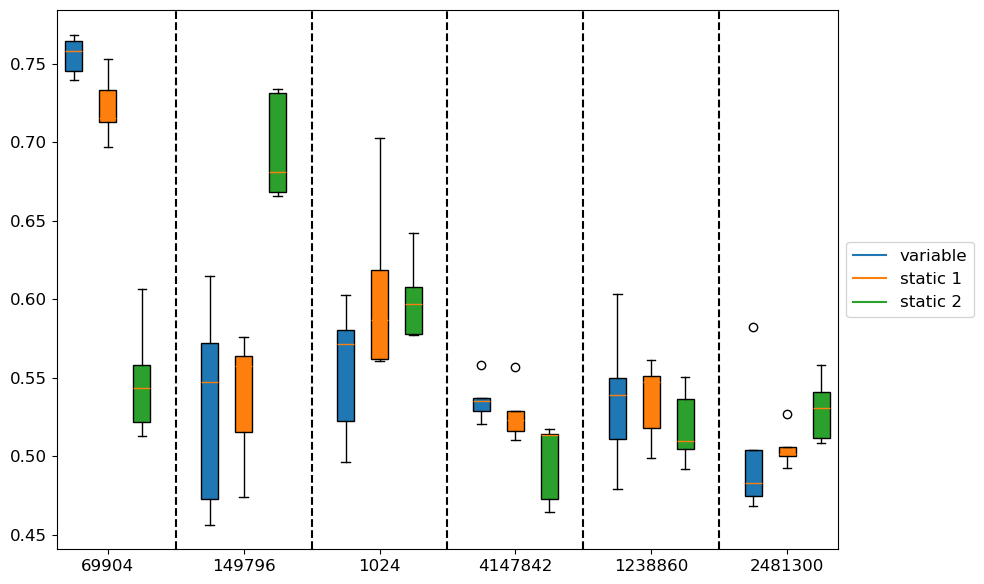

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['C0', 'C1', 'C2']
# Loop through each DataFrame and plot the boxplots
for i, df in enumerate(dfs):
    # Plot the boxplot, with positions offset for each dataframe
    bp = ax.boxplot(df.values, positions=np.arange(df.shape[1]) * (len(dfs) + 1) + i, patch_artist=True)
    # Set the box colors
    for box in bp['boxes']:
        box.set(facecolor=colors[i])
ax.set_xticks(np.arange(varied_df.shape[1]) * (len(dfs) + 1) + 1)
ax.set_xticklabels(varied_df.columns)

# Create legend for the colors
labels=["variable", "static 1", "static 2"]
for i, color in enumerate(colors):
    ax.plot([], c=color, label=labels[i])

# Add legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in range(1, varied_df.shape[1]):
    # Position the line between each set
    x_position = i * (len(dfs) + 1) - 1
    ax.axvline(x=x_position, color='black', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Unseen')

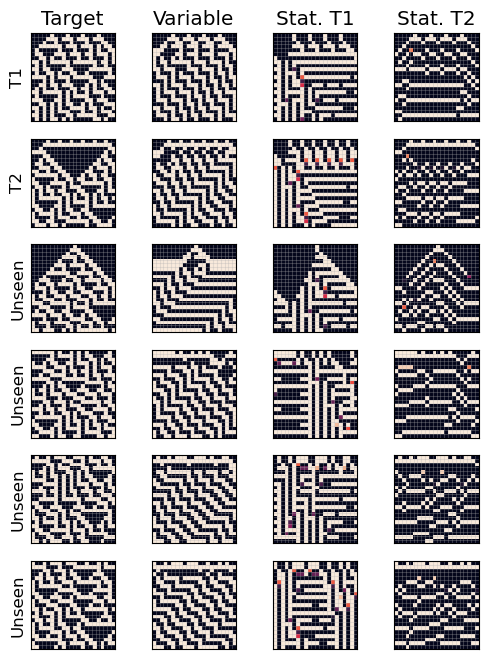

In [65]:
fig, axs = plt.subplots(6, 4, figsize=(6, 8), sharex=True, sharey=True)

plt.rcParams.update({"font.size": 12})

rep_id=0

for i in range(6):#looping through seeds
    helper.imshow_ca(all_targs[i], ax=axs[i,0])
    helper.imshow_ca(varied_phenos[i,rep_id,:,:], ax=axs[i,1])
    helper.imshow_ca(env1_phenos[i,rep_id,:,:], ax=axs[i,2])
    helper.imshow_ca(env2_phenos[i,rep_id,:,:], ax=axs[i,3])

axs[0,0].set_title('Target')
axs[0,1].set_title('Variable')
axs[0,2].set_title('Stat. T1')
axs[0,3].set_title('Stat. T2')

axs[0,0].set_ylabel("T1")
axs[1,0].set_ylabel("T2")
axs[2,0].set_ylabel("Unseen")
axs[3,0].set_ylabel("Unseen")
axs[4,0].set_ylabel("Unseen")
axs[5,0].set_ylabel("Unseen")

# The genomes

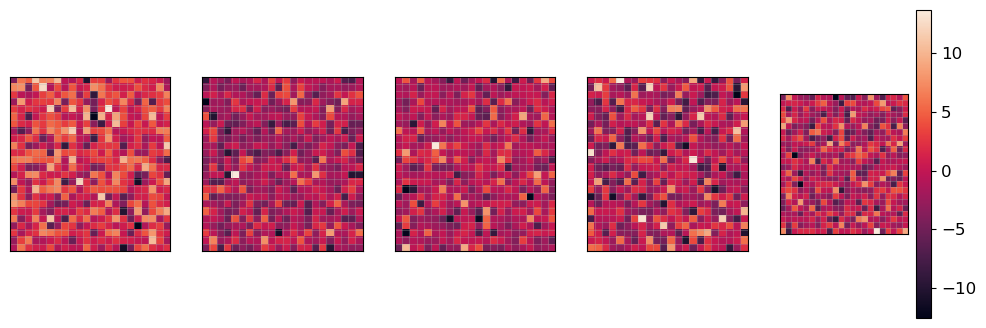

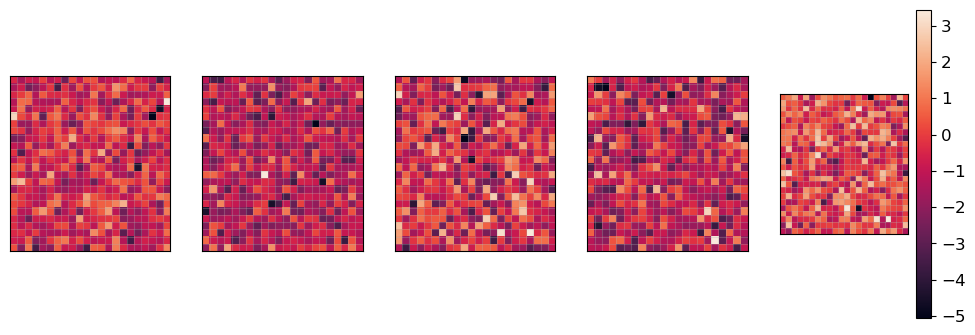

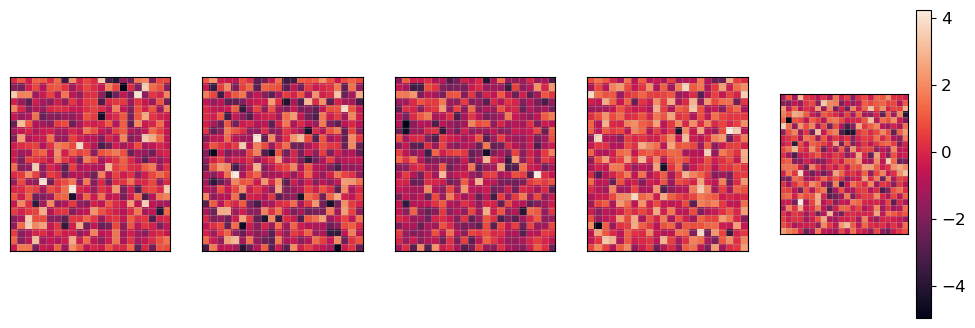

In [66]:
fig, axs = plt.subplots(ncols=5, nrows = 1, figsize=(12, 4))
for i,g in enumerate(varied_genos):
    im = helper.imshow_ca(g, ax=axs[i])
    if i == len(varied_genos)-1:
        fig.colorbar(im, ax=axs[-1])

fig, axs = plt.subplots(ncols=5, nrows = 1, figsize=(12, 4))
for i,g in enumerate(env1_genos):
    im = helper.imshow_ca(g, ax=axs[i])
    if i == len(env1_genos)-1:
        fig.colorbar(im, ax=axs[-1])

fig, axs = plt.subplots(ncols=5, nrows = 1, figsize=(12, 4))
for i,g in enumerate(env2_genos):
    im = helper.imshow_ca(g, ax=axs[i])
    if i == len(env2_genos)-1:
        fig.colorbar(im, ax=axs[-1])

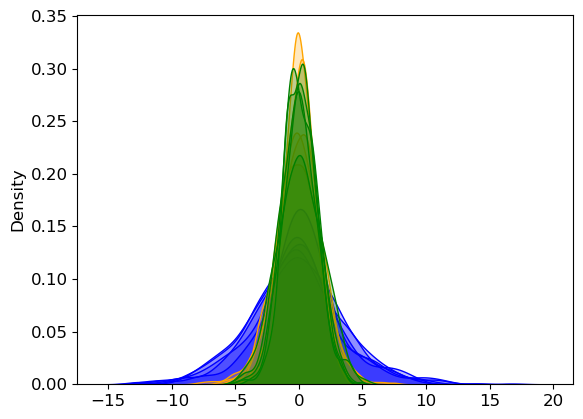

In [67]:
warnings.simplefilter(action='ignore', category=FutureWarning)
for i,g in enumerate(varied_genos):
    sns.kdeplot(g.flatten(),fill=True,color="blue")
for i,g in enumerate(env1_genos):
    sns.kdeplot(g.flatten(),fill=True,color="orange")
for i,g in enumerate(env2_genos):
    sns.kdeplot(g.flatten(),fill=True,color="green")
    

# Diversifiers

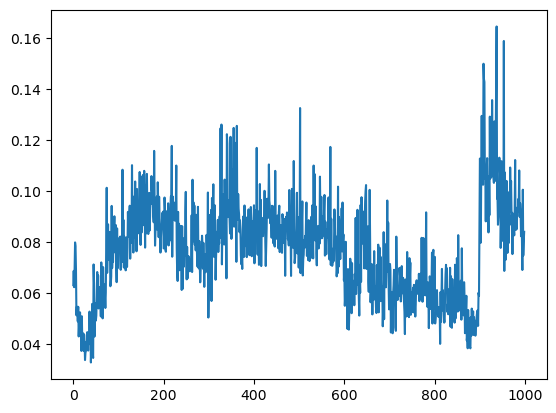

In [2]:
import os

root="results_testing_saving/"

season_len = 300
rules = [70,70]
rule = 70
seed_ints = [69904,149796]
metric = "beststd"

vari_beststds=[np.loadtxt(os.path.expanduser(root+f"stats_{season_len}_{rules[0]}-{rules[1]}_{seed_ints[0]}-{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(2)]

plt.plot(vari_beststds[0])

In [3]:
int_generation = np.argmax(vari_beststds[0])
vari_beststds[0][int_generation]

0.1646995952509189

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


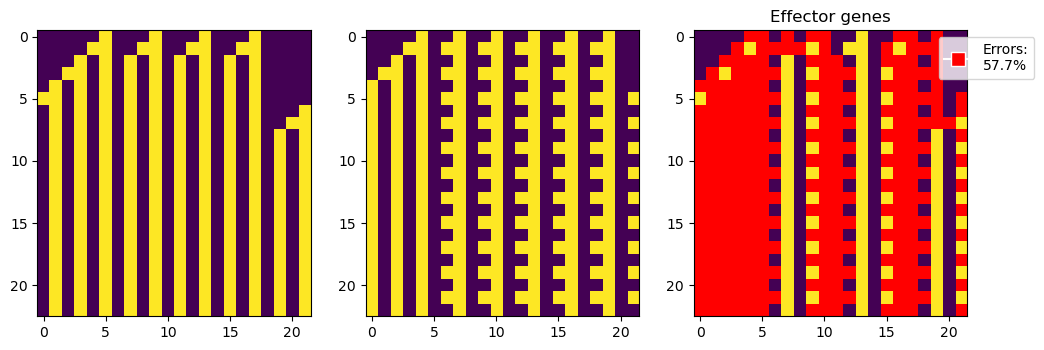

(1, 24, 22)


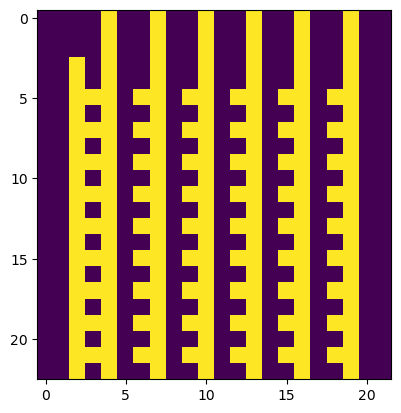

children


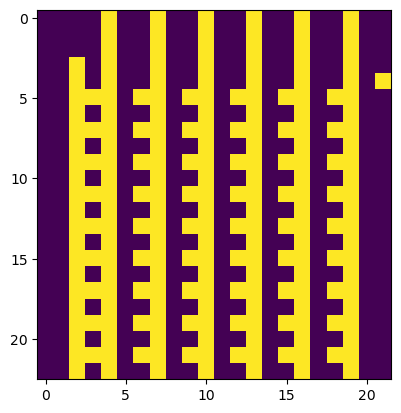

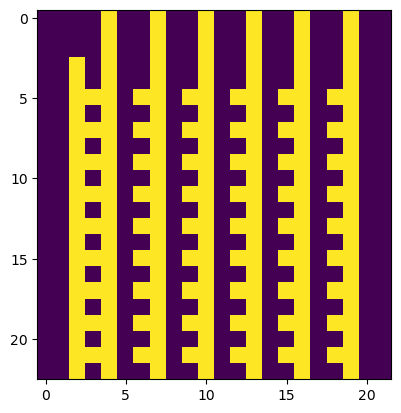

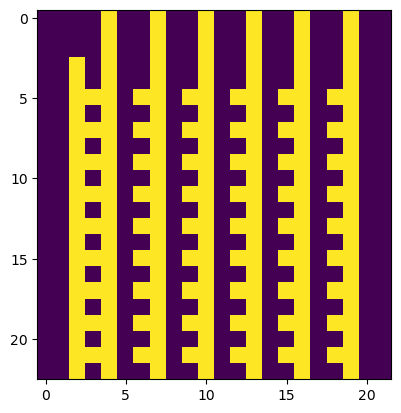

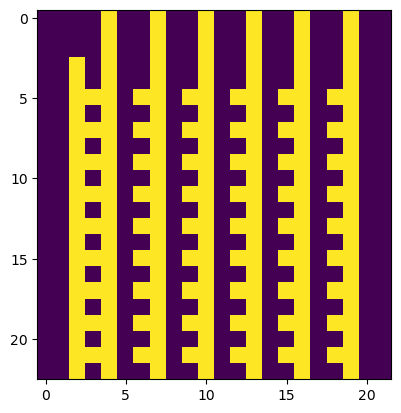

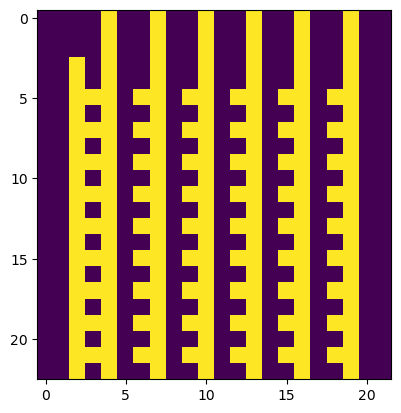

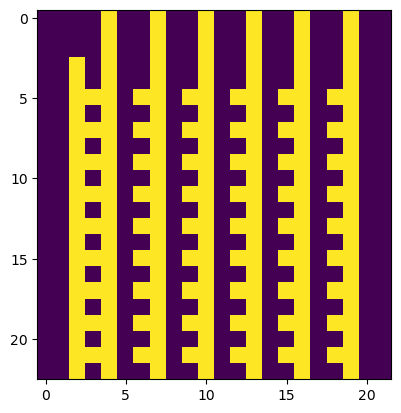

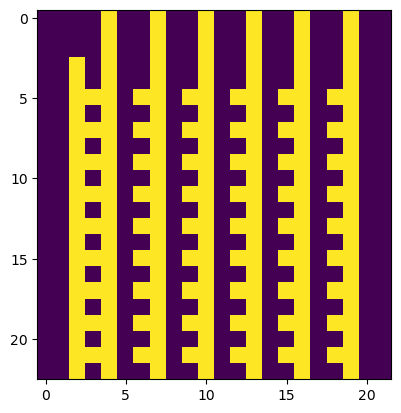

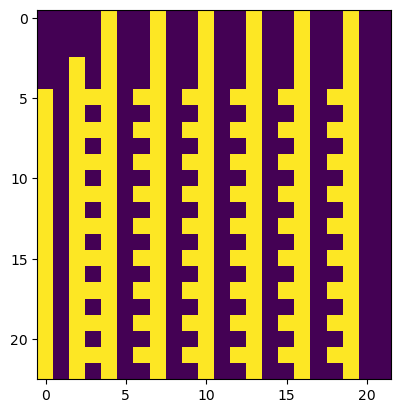

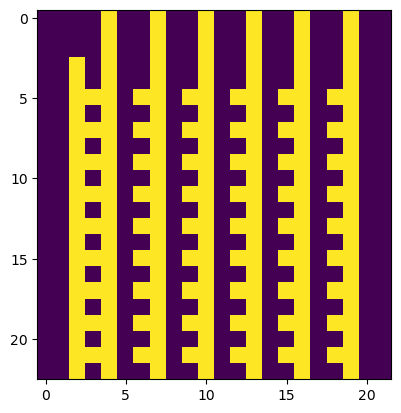

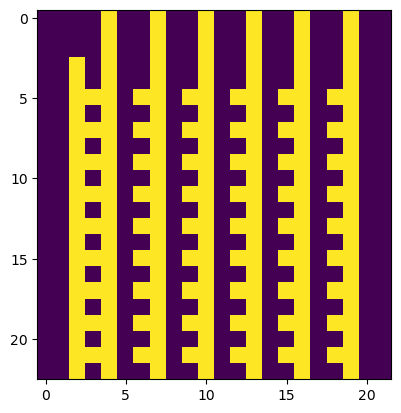

In [4]:
# Load GRN
# Parameters
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1 #which gene was used to get fitness
mut_rate = 0.1
mut_size = 0.5
try_seedints = [69904,149796,1024, 4147842,1238860,2481300]

#Targets
all_targs=[]
for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, rule, s)
    all_targs.append(targets)

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
axs[0].imshow(all_targs[0])
axs[1].imshow(all_targs[1])
helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])
plt.show()

#Check GRNs
runid=0
filename = f"{root}/stats_300_{rule}-{rule}_{seed_ints[0]}-{seed_ints[1]}_{runid+1}" + "_best_grn_std.txt"
grns = np.loadtxt(filename)
num_grns = int(grns.shape[0]/(grn_size+2)/grn_size)
grns = grns.reshape(num_grns,grn_size+2,grn_size)
#int_generation = -1
grn = grns[int_generation,:,:]
if len(grn.shape) == 2:
    grn = np.expand_dims(grn, axis=0)
print(grn.shape)
targets, phenos, fitnesses = helper.get_pop_TPF(grn, len(grn), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])
plt.imshow(phenos[0])
plt.show()

#Make children
num_child = 10
num_genes_mutate = int((grn_size + 2) * grn_size * grn.shape[0] * mut_rate)
children = np.tile(grn, (num_child, 1, 1))

mutations = np.random.randn(num_genes_mutate) * mut_size
x, y, z = children.shape
xs = np.random.choice(x, size=num_genes_mutate)
ys = np.random.choice(y, size=num_genes_mutate)
zs = np.random.choice(z, size=num_genes_mutate)
children[xs, ys, zs] = children[xs, ys, zs] + mutations

all_phenos=[]
fits = []
for s in try_seedints:
    targets, phenos, fitnesses = helper.get_pop_TPF(children, len(children), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])
    all_phenos.append(phenos)
    fits.append(fitnesses)
all_phenos = np.array(all_phenos)
fits = np.array(fits)

print("children")
for p in all_phenos[0]:
    plt.imshow(p)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


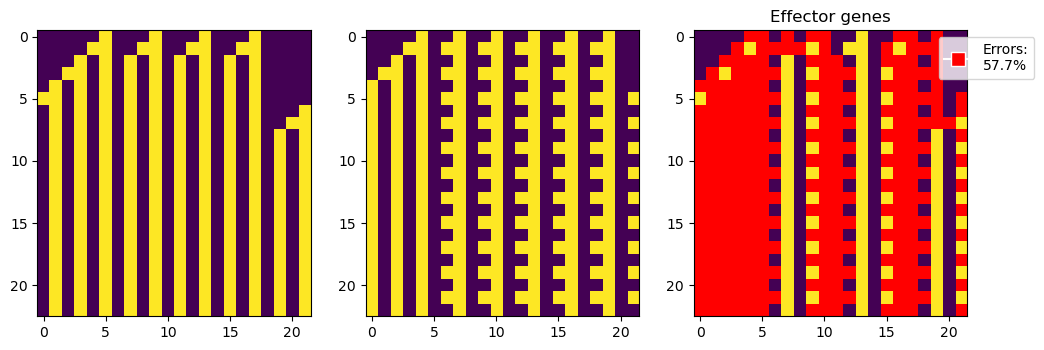

In [5]:
pop_size = 100
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1
rule = 90
rules=[70]#[30,50,54,62,90,94,102,110,150,254,22, 126, 146, 154, 82, 86, 18, 118, 122, 70]

try_seedints = [69904,149796]

for r in rules:
    print(r)
    all_targs=[]
    for s in try_seedints:
        random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
        #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
        start_pattern = helper.seedID2string(s, num_cells)
        start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
        targets = helper.rule2targets_wrapped_wstart(int(r), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        all_targs.append(targets)

    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
    axs[0].imshow(all_targs[0])
    axs[1].imshow(all_targs[1])
    helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])
    plt.show()

#all_targs[1]= 1-all_targs[0]

In [1]:
import numpy as np
import helper
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:132: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [14]:
pop_size = 20
grn_size=22
dev_steps = 22
geneid=1
rule = 22
num_cells = 22
try_seedints = [69904,149796]
all_targs=[]

for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
    start_pattern = helper.seedID2string(s, num_cells)
    start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
    targets = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    all_targs.append(targets)

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])



In [38]:
#fitnesses1=[0.5, 0.5, 1, 0]
#fitnesses2=[1, 0, 0.5, 0.5] #close, far, close, far

fitnesses1=[0.5,0.5]
fitnesses2=[1,0]

fitnesses1=[0.636363,0]
fitnesses2=[1,0.36363636]

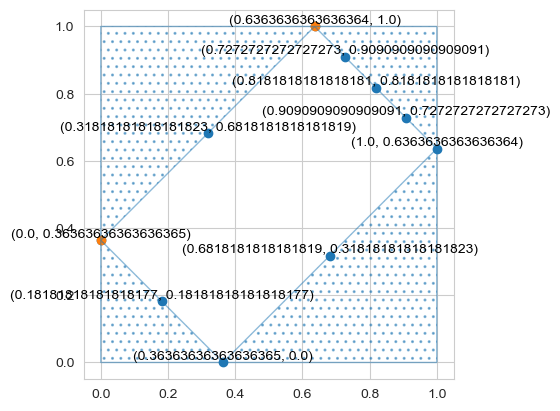

,x,y
0,1.000000,0.636364
1,0.636364,1.000000
2,0.818182,0.818182
3,0.909091,0.727273
4,0.727273,0.909091
5,0.000000,0.363636
6,0.363636,0.000000
7,0.181818,0.181818
8,0.681818,0.318182
9,0.318182,0.681818


In [39]:
tdf = helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=True)
tdf

In [40]:
helper.calc_div_BH(fitnesses1, fitnesses2, tdf)

1.036523113726489
[6.36363636e-07 8.99954088e-01]
[0.99999939 0.13175686]
[0.99999877 0.01735987]
0.5086793205313442
end of dists --------
0.31818166000000003
1.0


0.7543396602656721

In [37]:
helper.calc_div_BH(fitnesses1, fitnesses2, tdf)

1.036523113726489
[6.36363636e-07 8.99954088e-01]
[0.99999939 0.13175686]
[0.99999877 0.01735987]
0.5086793205313442
end of dists --------
0.31818166000000003
1.0


0.7543396602656721

In [ ]:
#collapses to 1 line only if targ A = 1 - targ B

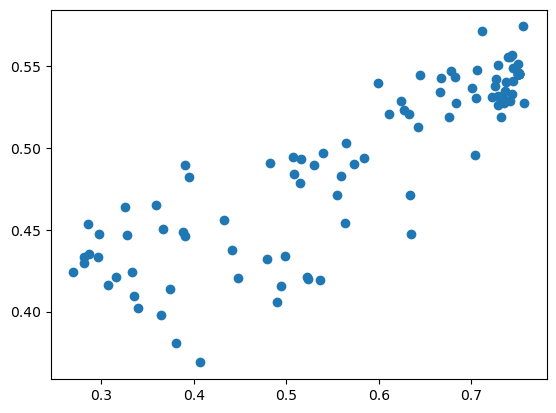

In [112]:
pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])

plt.scatter(fitnesses1,fitnesses2)

#diver_score = dist_maxs + std_2d


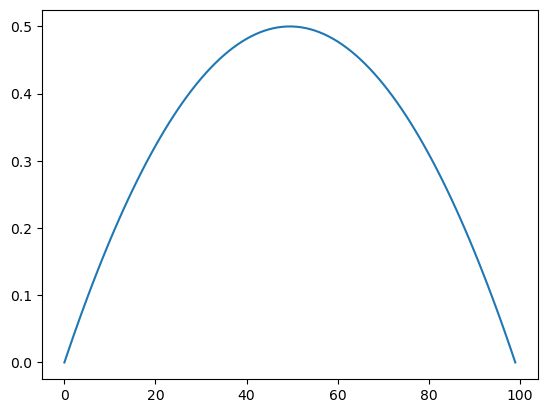

In [65]:
def dist(x, y):
    return np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1])**2)

a = [0, 0.4]
b = [1, 0.6]
c = [1, 1 - a[0]]
d0 = [0, 1 - b[1]]

#ax1 = dist(a, c)
#ax2 = dist(b, d)

overlapo = 0.9#0.6
error = 1-overlapo#0.4
ls=[]
for i in np.linspace(0,1,100):
    overlapo = i
    error = 1-overlapo
    ls.append(1-(error*error + overlapo*overlapo))

plt.plot(ls)

In [120]:
pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])

pop = np.random.random(size=(pop_size, dev_steps+1, num_cells))
fitnesses1 = -np.abs(pop - target1).sum(axis=1).sum(axis=1)
fitnesses1=1-(fitnesses1/worst) #0-1 scaling
fitnesses2 = -np.abs(pop - target2).sum(axis=1).sum(axis=1)
fitnesses2=1-(fitnesses2/worst) #0-1 scaling

pop = np.random.randint(0, high = 2, size=(pop_size, dev_steps+1, num_cells))
fitnesses1 = -np.abs(pop - target1).sum(axis=1).sum(axis=1)
fitnesses1=1-(fitnesses1/worst) #0-1 scaling
fitnesses2 = -np.abs(pop - target2).sum(axis=1).sum(axis=1)
fitnesses2=1-(fitnesses2/worst) #0-1 scaling


pop_df = pd.DataFrame()
pop_df["x"]=fitnesses1
pop_df["y"]=fitnesses2

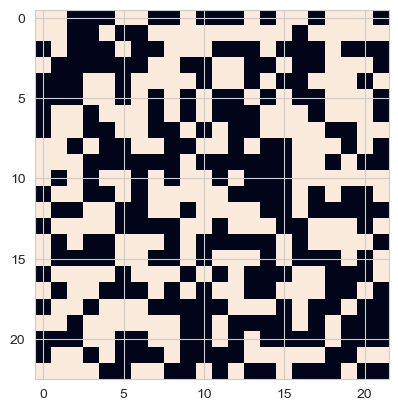

In [121]:
plt.imshow(pop[0])

/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

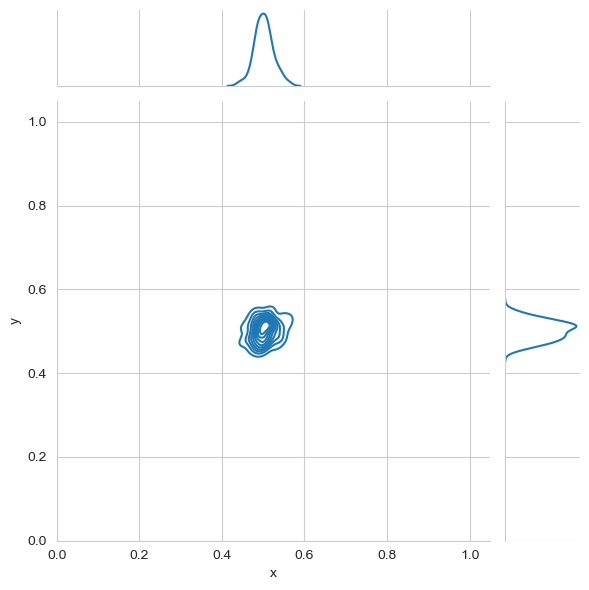

In [122]:
sns.set_style("whitegrid")
jnt = sns.jointplot(data=pop_df, x="x", y="y",kind="kde")

plt.xlim(0,1.05)
plt.ylim(0,1.05)

plt.show()


In [ ]:
#----------------------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


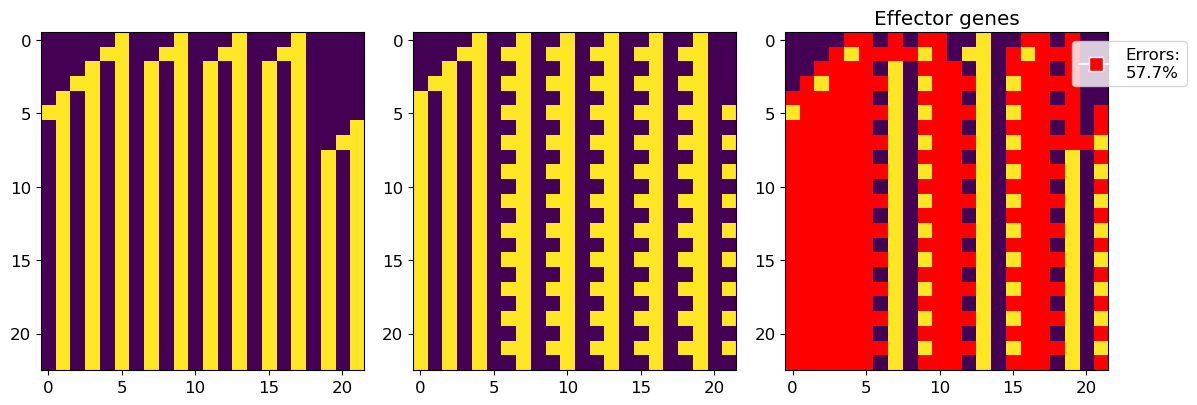

In [124]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
#Plot best phenotype
axs[0].imshow(all_targs[0])
#Plot target
axs[1].imshow(all_targs[1])
#Plot difference
helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])

plt.tight_layout()
plt.show()



In [ ]:
fname=f"results_new_rules/stats_300_{rule}-{rule}_69904-149796" + "_" + str(1)
f=np.loadtxt(fname + "_both_fits.txt")
print(f.shape[0]/2/pop_size)
num_generations=int(f.shape[0]/2/pop_size)
f=f.reshape(num_generations,2,pop_size)
f.shape

In [ ]:

for x,i in enumerate(f):
    plt.plot(i[0,:],i[1,:],".")
    xmean=np.mean(i[0,:])
    ymean=np.mean(i[1,:])
    plt.plot(xmean, ymean, "x")
    print(xmean)
    print(np.max(i[0,:]))
    print(saveat[x])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()